# [2차 EDA] 1차 선별기업에 대한 추가작업 
### 1. 작업 방향
- 1차 선별기업별 매출액 증가율 계산 및 시각화 진행
- 이에 따른 인사이트 발견

### 2. 선별 기업 리스트

> 연매출액 100억 이상 조건 : [126814, 294387, 294337, 294367, 126538, 126674, 126664, 126983, 227414, 126606, 126831, 227415, 403359, 403434, 469458, 126802, 419945, 403462, 469677, 420046]

> 연매출액 100억 & 직원수 30명 이상 조건 : [294387, 294337, 294367, 126538, 126664, 126983, 227414, 227415, 403359, 469458, 126802, 469677]

### 기타] 국민연금 인당금액 산정
- 인당 금액은 단순 계산 방식으로 진행 (월별 연금보험료 / 직원수) 

> 월 국민연금 납부액은 기준소득월액의 9%(사업주와 개인이 4.5%씩 부담)

    - 2020년 기준소득월액 상한액 : 503만원
    - 국민연금 보험료 최고 452,700원 

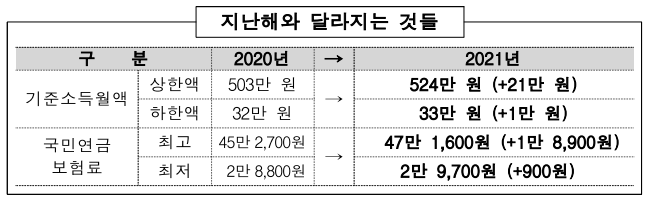

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

#한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

data = pd.read_csv('company_nps_data.csv', encoding='cp949')

cor_id= [126538, 126606, 126664, 126674, 126802, 126814, 126831, 126983, 227414, 227415] #선정된 id들 : 10개

df = data.loc[data['회사ID'].isin(cor_id)]
df

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
387,126606,1035707054,2018,4,342894700,937
456,126831,1753200162,2016,4,213087620,584
546,126664,323278620,2017,1,250633620,812
597,227414,4644329868,2017,9,906576960,2360
960,126664,353839107,2018,7,285948920,838
...,...,...,...,...,...,...
98849,126674,474963360,2015,12,267413520,832
99228,126674,480114248,2016,2,261403300,813
99317,126814,627641511,2018,5,148514140,593
99635,126538,671580655,2016,10,380370640,1214


## 원본 데이터 불러오기

In [124]:
import pandas as pd

df = pd.read_csv('./company_nps_data.csv', encoding='cp949')
df

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151
...,...,...,...,...,...,...
99796,171439,4630622,2017,2,2402740,11
99797,239388,1045021,2018,10,1428800,9
99798,272304,181898,2018,3,392560,4
99799,362194,2100218,2018,12,874780,3


In [125]:
# 중복 제거한 기업 아이디 추출 
a = [126814, 294387, 294337, 294367, 126538, 126674, 126664, 126983, 227414, 126606, 126831, 227415, 403359, 403434, 469458, 126802, 419945, 403462, 469677, 420046,
     294387, 294337, 294367, 126538, 126664, 126983, 227414, 227415, 403359, 469458, 126802, 469677]

b = set(a)
print(' 선별기업 전체 : ', len(a), '\n', '중복 제거한 기업 수 : ', len(b))
print('='*30)
print('중복 제거 기업 리스트 : ') 
b

 선별기업 전체 :  32 
 중복 제거한 기업 수 :  20
중복 제거 기업 리스트 : 


{126538,
 126606,
 126664,
 126674,
 126802,
 126814,
 126831,
 126983,
 227414,
 227415,
 294337,
 294367,
 294387,
 403359,
 403434,
 403462,
 419945,
 420046,
 469458,
 469677}

# 함수 정의

In [126]:
# 매출액 증가율 함수
# (공식) 매출액증가율(%) = (당기매출액-전기매출액)/전기매출 *100
def sales_up_rate(company_id):
    temp = df.loc[df['회사ID'] == company_id, :]

    # '회사ID', '년도', '월' 기준으로 오름차순 정렬한 데이터프레임 생성 
    sorted_df = temp.sort_values(by=['회사ID', '년도', '월'], axis=0)
    sorted_df.reset_index(drop=True, inplace=True)

    # 회사 id별로 매출액 증가율 계산 
    sales_rate = sorted_df.drop_duplicates(['연매출액'], keep = 'first')
    sales_rate['매출액증가율'] = 0
    for i in range(1, len(sales_rate)):
        sales_rate['매출액증가율'].iloc[i] = round((sales_rate['연매출액'].iloc[i]-sales_rate['연매출액'].iloc[i-1])
        /sales_rate['연매출액'].iloc[i-1]*100, 4)
    
    # 필요없는 컬럼 정리
    sales_rate.drop(['월', '월별_연금보험료', '월별_직원수'], axis=1, inplace=True)

    #최종 데이터 프레임 리턴
    return sales_rate  # 데이터 프레임 리턴 

In [127]:
def add_ym(company_id):
    # 기업별 자료 추출 및 데이터 정렬
    com = df.loc[df['회사ID'] == company_id, :]
    com.sort_values(by=['년도', '월'], axis=0, inplace=True)
    com.reset_index(drop=True, inplace=True)

    # 년월 파생변수 만들어주기 
    년월 = com['년도'].map(str) + "-" + com['월'].map(str) #연도와 월 합침
    com.insert(2, '년월',년월)

    # 인당 연금보험료 파생변수 만들어주기(연금보험료/직원수)
    # 국민연금은 급여의 4.5%를 근로자와 사업주가 각각 공제
    인당_연금보험료 = round(com['월별_연금보험료']/com['월별_직원수'], 2)
    com.insert(7, '인당_연금보험료',인당_연금보험료)

    # (파생변수 추가+정렬)된 데이터프레임 리턴
    return com

# 1. 126538 기업 분석

In [128]:
# 해당 기업만 데이터 뽑아 정리
df_126538 = add_ym(126538)
df_126538.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,126538,605381377,2015-11,2015,11,346524780,1156,299761.92
1,126538,605381377,2015-12,2015,12,345882420,1162,297661.29
2,126538,671580655,2016-1,2016,1,346646300,1164,297806.10
3,126538,671580655,2016-2,2016,2,345650180,1162,297461.43
4,126538,671580655,2016-3,2016,3,345654380,1151,300307.89


In [176]:
# 기술 통계량 
df_126538[['연매출액','월별_연금보험료','월별_직원수','인당_연금보험료']].describe().style.background_gradient(cmap='coolwarm')
# df_126538.describe()

,연매출액,월별_연금보험료,월별_직원수,인당_연금보험료
count,38.000000,38.000000,38.000000,38.000000
mean,698283164.263158,396866791.052632,1256.473684,315561.580526
std,31472348.966721,30467808.052272,60.637932,13489.711247
min,605381377.000000,345650180.000000,1151.000000,296526.490000
25%,671580655.000000,377602375.000000,1211.000000,304863.007500
50%,716851120.000000,401068280.000000,1263.500000,313370.840000
75%,721901349.000000,422069195.000000,1302.250000,325914.225000
max,721901349.000000,432795480.000000,1363.000000,337812.720000


In [130]:
# 년도별 평균값
df_126538.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,126538.000000,605381377.000000,11.500000,346203600.000000,1159.000000,298711.605000
2016,126538.000000,671580655.000000,6.500000,365333766.666667,1200.333333,304230.663333
2017,126538.000000,716851120.000000,6.500000,413020753.333333,1308.166667,315651.373333
2018,126538.000000,721901349.000000,6.500000,420689718.333333,1277.166667,329611.034167


In [131]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_126538[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.841869,0.757423
월별_연금보험료,0.841869,1.000000,0.873712
월별_직원수,0.757423,0.873712,1.000000


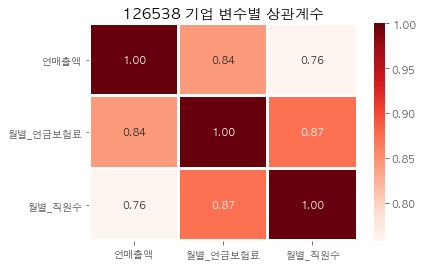

In [132]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('126538 기업 변수별 상관계수')
plt.show()

<Figure size 720x1224 with 0 Axes>

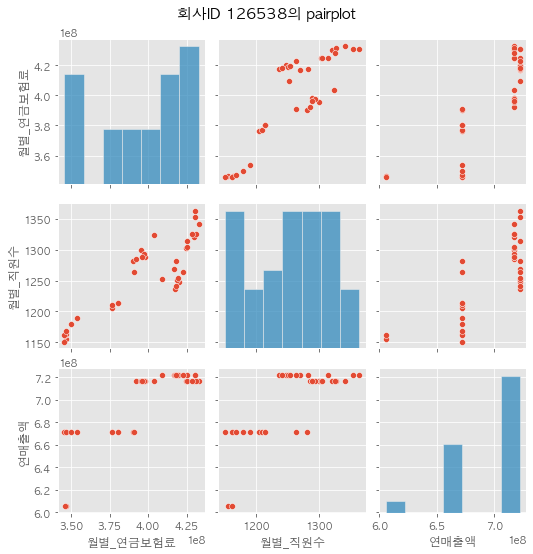

In [133]:
# pairplot
import seaborn as sns
# sns.set_theme(style="ticks")
plt.figure(figsize=(10, 17))
sns.pairplot(df_126538[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_126538['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

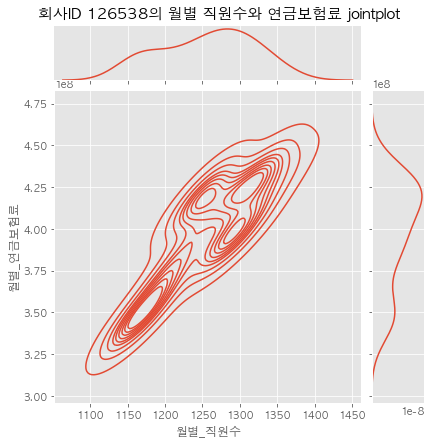

In [134]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_126538['월별_직원수'], y=df_126538['월별_연금보험료'], kind='kde')
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_126538['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

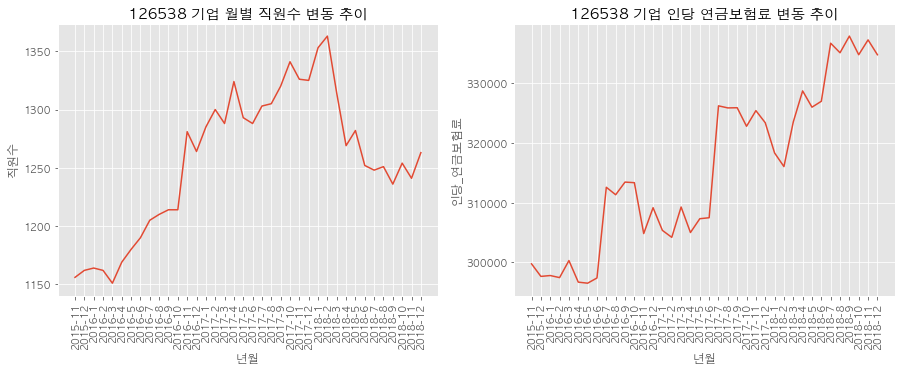

In [135]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_126538['년월'], y=df_126538['월별_직원수'])
plt.xticks(rotation=90)
plt.title('126538 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_126538['년월'], y=df_126538['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('126538 기업 인당 연금보험료 변동 추이')
plt.show()

In [136]:
# 매출액 증가율 계산 
sales_126538 = sales_up_rate(126538) # 원하는 기업 아이디 넣어주면 됨 
sales_126538

,회사ID,연매출액,년도,매출액증가율
0,126538,605381377,2015,0.0000
2,126538,671580655,2016,10.9351
14,126538,716851120,2017,6.7409
26,126538,721901349,2018,0.7045


In [201]:
# 평균 매출 증가율
sales_126538['매출액증가율'].mean()
print('회사ID 126538 연평균 매출 증가율 {}'.format(sales_126538['매출액증가율'].mean()))

회사ID 126538 연평균 매출 증가율 4.595125


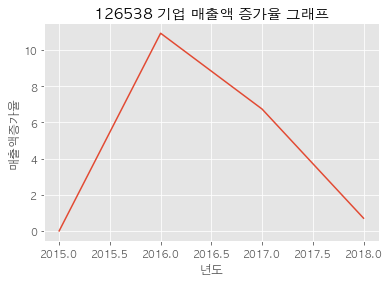

In [137]:
# 매출액 증가율 그래프 

sns.lineplot(data=sales_126538, x='년도', y='매출액증가율')
plt.title('126538 기업 매출액 증가율 그래프')
plt.show()

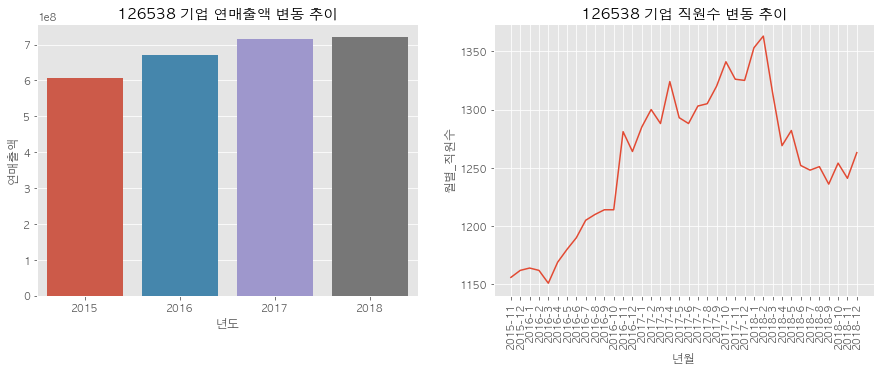

In [138]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_126538['년도'], y=sales_126538['연매출액'])
plt.title('126538 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_126538['년월'], y=df_126538['월별_직원수'])
plt.xticks(rotation=90)
plt.title('126538 기업 직원수 변동 추이')
plt.show()

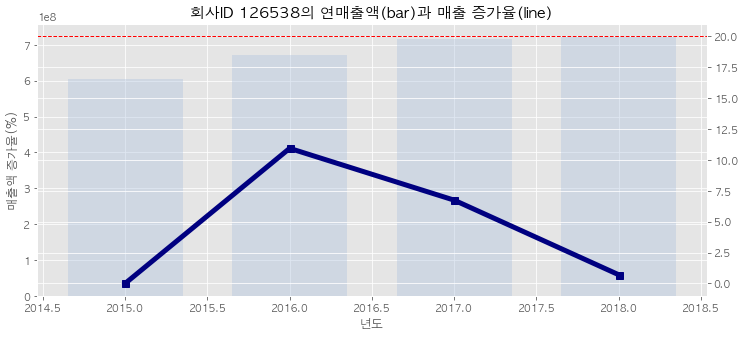

In [166]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126538)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126538" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

# *******이하 나머지 기업들도 동일한 작업 진행 예정

# 2. 126606 기업 분석

In [139]:
df_126606 = add_ym(126606)
df_126606.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,126606,937184426,2015-11,2015,11,333462780,998,334131.04
1,126606,937184426,2015-12,2015,12,333378620,998,334046.71
2,126606,980566803,2016-1,2016,1,323608700,972,332930.76
3,126606,980566803,2016-2,2016,2,324073560,972,333409.01
4,126606,980566803,2016-3,2016,3,323728500,971,333397.01


In [140]:
# 기술 통계량 
df_126606[['연매출액','월별_연금보험료','월별_직원수']].describe().style.background_gradient(cmap='coolwarm')

,연매출액,월별_연금보험료,월별_직원수
count,38.000000,38.000000,38.000000
mean,1011756027.263158,342666963.157895,968.026316
std,30456116.117316,14727595.192661,21.032134
min,937184426.000000,322498560.000000,927.000000
25%,980566803.000000,330925380.000000,958.000000
50%,1031422825.000000,341763400.000000,969.500000
75%,1035707054.000000,352908370.000000,977.000000
max,1035707054.000000,372645660.000000,1007.000000


In [141]:
# 년도별 평균값
df_126606.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,126606.000000,937184426.000000,11.500000,333420700.000000,998.000000,334088.875000
2016,126606.000000,980566803.000000,6.500000,331656771.666667,976.583333,339622.770000
2017,126606.000000,1031422825.000000,6.500000,342421280.000000,969.916667,353007.814167
2018,126606.000000,1035707054.000000,6.500000,355463881.666667,952.583333,373152.618333


In [142]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_126606[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.549513,-0.492198
월별_연금보험료,0.549513,1.000000,0.012853
월별_직원수,-0.492198,0.012853,1.000000


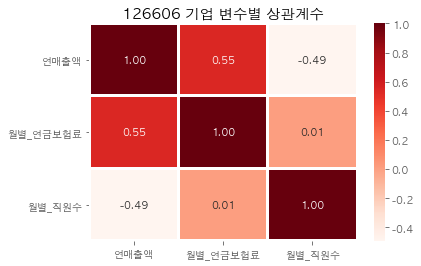

In [143]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('126606 기업 변수별 상관계수')
plt.show()

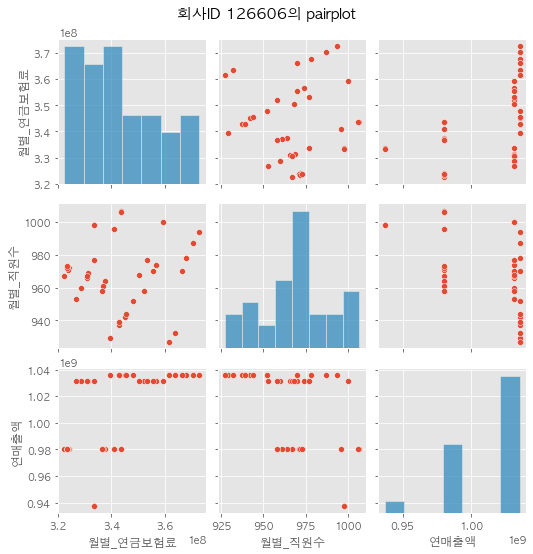

In [144]:
sns.pairplot(df_126606[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_126606['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

In [145]:
# 매출액 증가율 계산
sales_126606 = sales_up_rate(126606)
sales_126606

,회사ID,연매출액,년도,매출액증가율
0,126606,937184426,2015,0.0000
2,126606,980566803,2016,4.6290
14,126606,1031422825,2017,5.1864
26,126606,1035707054,2018,0.4154


In [181]:
# 평균 매출 증가율
sales_126606['매출액증가율'].mean()
print('회사ID 126606 연평균 매출 증가율 {}'.format(sales_126606['매출액증가율'].mean()))

회사ID 126606 연평균 매출 증가율 2.5577


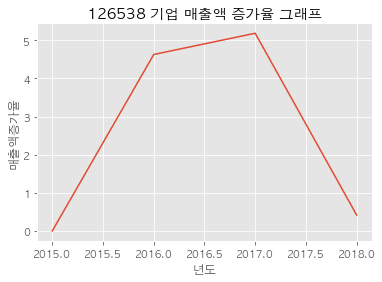

In [146]:
# 매출액 증가율 그래프 
sns.lineplot(data=sales_126606, x='년도', y='매출액증가율')
plt.title('126538 기업 매출액 증가율 그래프')
plt.show()

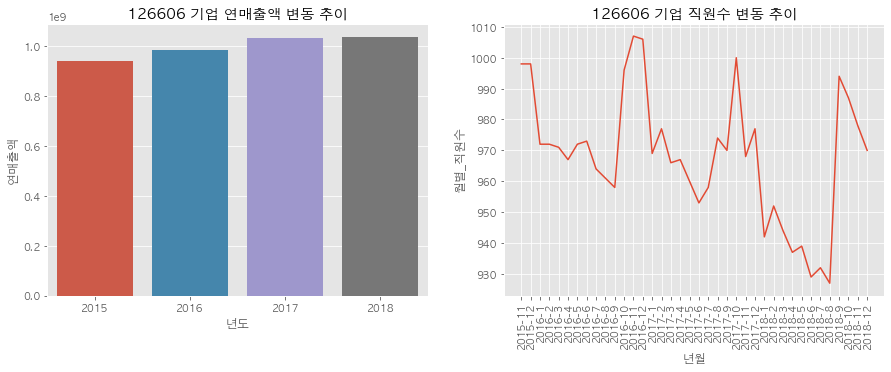

In [147]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_126606['년도'], y=sales_126606['연매출액'])
plt.title('126606 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_126606['년월'], y=df_126606['월별_직원수'])
plt.xticks(rotation=90)
plt.title('126606 기업 직원수 변동 추이')
plt.show()

# 3. 126664 기업분석

In [182]:
# 3
sales_126664 = sales_up_rate(126664)
sales_126664

,회사ID,연매출액,년도,매출액증가율
0,126664,256505233,2015,0.0000
2,126664,304408150,2016,18.6752
14,126664,323278620,2017,6.1991
26,126664,353839107,2018,9.4533


In [183]:
# 평균 매출 증가율
sales_126664['매출액증가율'].mean()
print('회사ID 126664 연평균 매출 증가율 {}'.format(sales_126664['매출액증가율'].mean()))

회사ID 126664 연평균 매출 증가율 8.5819


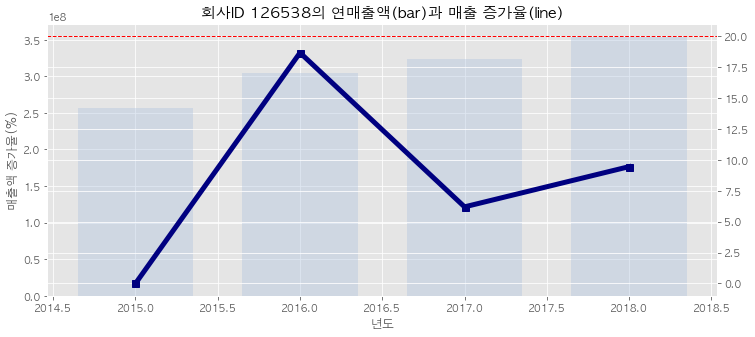

In [167]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126664)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126664" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [185]:
# 4
sales_126674 = sales_up_rate(126674)
sales_126674

,회사ID,연매출액,년도,매출액증가율
0,126674,474963360,2015,0.0000
2,126674,480114248,2016,1.0845
14,126674,531267060,2017,10.6543
26,126674,524068949,2018,-1.3549


In [186]:
# 평균 매출 증가율
sales_126674['매출액증가율'].mean()
print('회사ID 126674 연평균 매출 증가율 {}'.format(sales_126674['매출액증가율'].mean()))

회사ID 126674 연평균 매출 증가율 2.5959749999999997


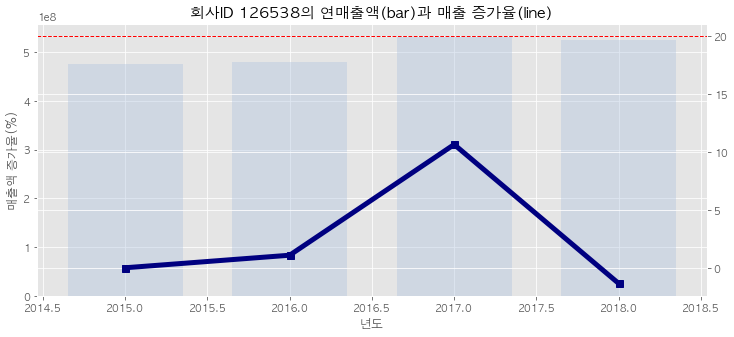

In [168]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126674)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126674" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [187]:
# 5
sales_126802 = sales_up_rate(126802)
sales_126802

,회사ID,연매출액,년도,매출액증가율
0,126802,80102292,2015,0.0000
2,126802,81859588,2016,2.1938
14,126802,154761834,2017,89.0577
26,126802,115619452,2018,-25.2920


In [188]:
# 평균 매출 증가율
sales_126802['매출액증가율'].mean()
print('회사ID 126802 연평균 매출 증가율 {}'.format(sales_126802['매출액증가율'].mean()))

회사ID 126802 연평균 매출 증가율 16.489874999999998


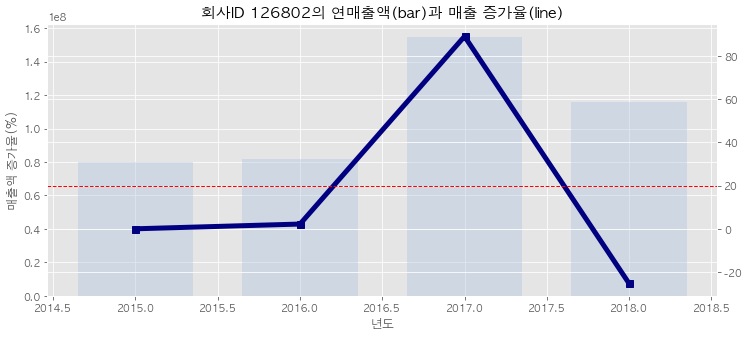

In [170]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126802)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126802" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [190]:
# 6
sales_126814 = sales_up_rate(126814)
sales_126814

,회사ID,연매출액,년도,매출액증가율
0,126814,421492545,2015,0.0000
2,126814,399262755,2016,-5.2741
14,126814,625604516,2017,56.6899
26,126814,627641511,2018,0.3256


In [191]:
# 평균 매출 증가율
sales_126814['매출액증가율'].mean()
print('회사ID 126814 연평균 매출 증가율 {}'.format(sales_126814['매출액증가율'].mean()))

회사ID 126814 연평균 매출 증가율 12.935350000000001


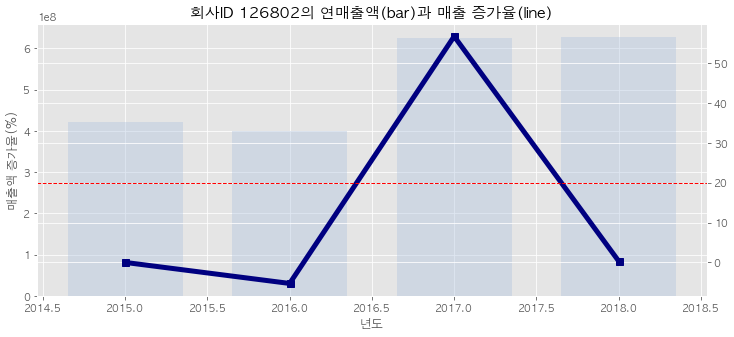

In [171]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126814)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126814" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [192]:
# 7
sales_126831 = sales_up_rate(126831)
sales_126831

,회사ID,연매출액,년도,매출액증가율
0,126831,2000958572,2015,0.0000
2,126831,1753200162,2016,-12.3820
14,126831,2102007007,2017,19.8954
26,126831,2206140616,2018,4.9540


In [193]:
# 평균 매출 증가율
sales_126831['매출액증가율'].mean()
print('회사ID 126831 연평균 매출 증가율 {}'.format(sales_126831['매출액증가율'].mean()))

회사ID 126831 연평균 매출 증가율 3.1168499999999995


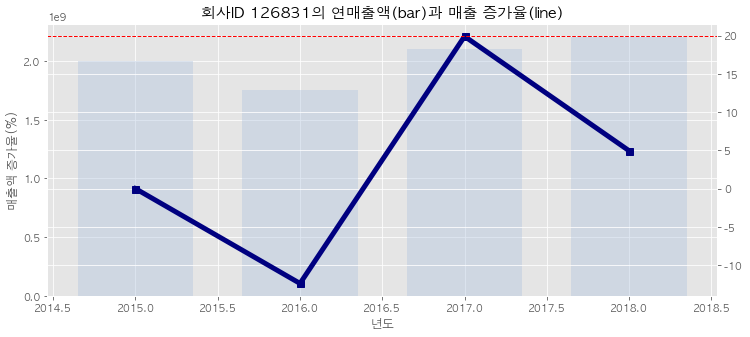

In [172]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126831)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126831" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [194]:
# 8
sales_126983 = sales_up_rate(126983)
sales_126983

,회사ID,연매출액,년도,매출액증가율
0,126983,119119899,2015,0.0000
2,126983,144618199,2016,21.4056
14,126983,151335859,2017,4.6451
26,126983,195570294,2018,29.2293


In [195]:
# 평균 매출 증가율
sales_126983['매출액증가율'].mean()
print('회사ID 126983 연평균 매출 증가율 {}'.format(sales_126983['매출액증가율'].mean()))

회사ID 126983 연평균 매출 증가율 13.82


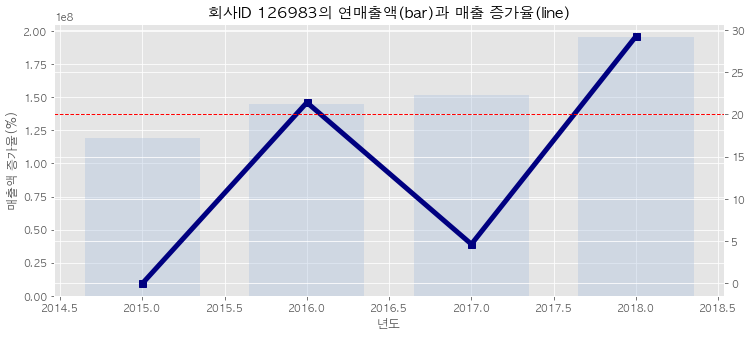

In [173]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126983)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 126983" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [197]:
# 9
sales_227414 = sales_up_rate(227414)
sales_227414

,회사ID,연매출액,년도,매출액증가율
0,227414,4047655229,2015,0.0000
2,227414,4210897523,2016,4.0330
14,227414,4644329868,2017,10.2931
26,227414,4933525226,2018,6.2268


In [198]:
# 평균 매출 증가율
sales_227414['매출액증가율'].mean()
print('회사ID 227414 연평균 매출 증가율 {}'.format(sales_227414['매출액증가율'].mean()))

회사ID 227414 연평균 매출 증가율 5.138225


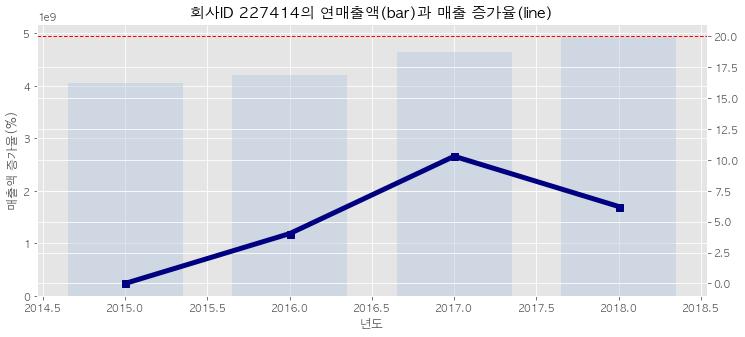

In [174]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(227414)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 227414" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

In [199]:
# 10
sales_227415 = sales_up_rate(227415)
sales_227415

,회사ID,연매출액,년도,매출액증가율
0,227415,4961710828,2015,0.0000
2,227415,5093598465,2016,2.6581
14,227415,5387846478,2017,5.7768
26,227415,5521038494,2018,2.4721


In [200]:
# 평균 매출 증가율
sales_227415['매출액증가율'].mean()
print('회사ID 227415 연평균 매출 증가율 {}'.format(sales_227415['매출액증가율'].mean()))

회사ID 227415 연평균 매출 증가율 2.72675


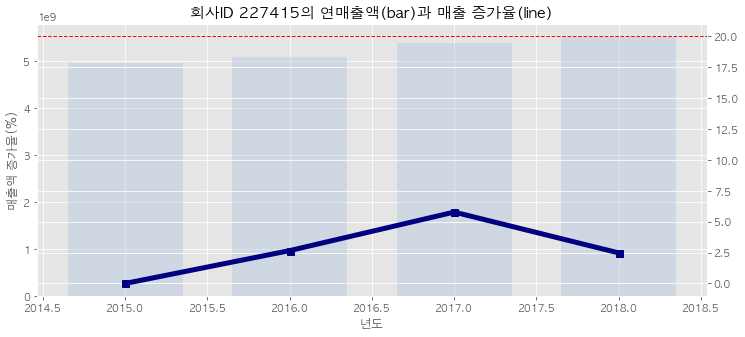

In [175]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(227415)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 227415" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

① 126538,
② 126606,
③ 126664,
④ 126674,
⑤ 126802,
⑥ 126814,
⑦ 126831,
⑧ 126983,
⑨ 227414,
⑩ 227415,

In [156]:
# def sales_up_rate(company_id):
#     global df
#     df = df.loc[df['회사ID'] == company_id, :]

#     # 이후 plot을 그리기 위해 년월 파생변수 만들어줌
#     a = list(map(str, df['년도']))
#     b = list(map(str, df['월']))
#     df['년월'] = 0
#     for i in range(len(df)):
#         df['년월'].iloc[i] = a[i]+'-'+b[i]

#     # '회사ID', '년도', '월' 기준으로 오름차순 정렬한 데이터프레임 생성 
#     sorted_df = df.sort_values(by=['회사ID', '년도', '월'], axis=0)
#     sorted_df.reset_index(drop=True, inplace=True)

#     # 회사 id별로 매출액 증가율 계산 
#     sales_rate = sorted_df.drop_duplicates(['연매출액'], keep = 'first')
#     sales_rate['매출액증가율'] = 0
#     for i in range(1, len(sales_rate)):
#         sales_rate['매출액증가율'].iloc[i] = round((sales_rate['연매출액'].iloc[i]-sales_rate['연매출액'].iloc[i-1])/sales_rate['연매출액'].iloc[i-1]*100, 4)
    
#     # 필요없는 컬럼 정리
#     sales_rate.drop(['월', '월별_연금보험료', '월별_직원수', '년월'], axis=1, inplace=True)

#     #최종 데이터 프레임 리턴
#     return sales_rate  # 데이터 프레임 리턴 

In [164]:
cor1 = df_126538.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,126538.0,605381377.0,11.5,3.462036e+08,1159.000000,298711.605000
1,2016,126538.0,671580655.0,6.5,3.653338e+08,1200.333333,304230.663333
2,2017,126538.0,716851120.0,6.5,4.130208e+08,1308.166667,315651.373333
3,2018,126538.0,721901349.0,6.5,4.206897e+08,1277.166667,329611.034167


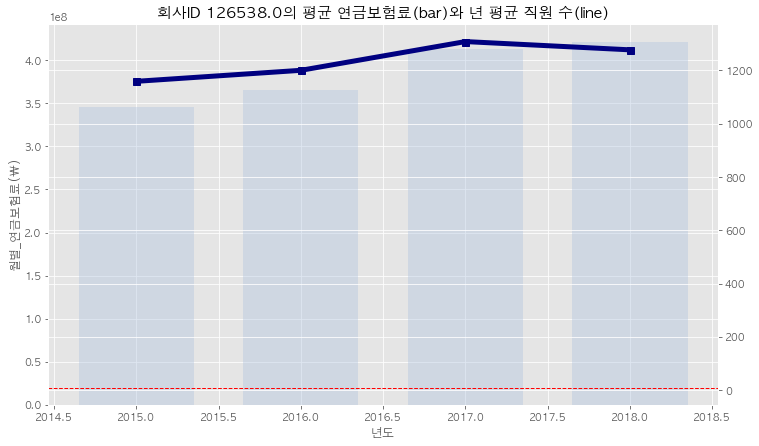

In [165]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()